# College Football Spread Betting Model

## Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from opponent_adjustments import get_opponent_adjustments
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings
import math
from tqdm import tqdm
import optuna
import Model_Functions as MF

## Config Inputs

In [2]:
# Config - Major Inputs
DB_PATH = "cfb_data.db"
PRE_GAME_ELO_CSV_PATH = 'games_with_pregame_elo.csv'
#Define RP metrics to load and use
RP_METRICS_TO_USE =['usage','percentPPA']
# Define dfault value for missing RP data (e.g., average)
DEFAULT_RP_VALUE = 0.5
# Define how many weeks RP features should be active
RP_ACTIVE_WEEKS = 4
#Betting Parameters
BET_THRESHOLD = 1.5
WIN_PAYOUT = 0.909
LOSS_AMOUNT = 1
# EWMA Parameters
EWMA_SPAN = 5
min_periods_for_ewma = max(1, EWMA_SPAN // 2)
# Train / Test Split Years
TRAIN_END_SEASON = 2020
VALIDATION_END_SEASON = 2022
TEST_START_SEASON = VALIDATION_END_SEASON + 1
# XG Boost Params
# Define XGBoost parameters (use reasonable defaults or slightly tuned values)
# We are NOT tuning hyperparameters here, just evaluating feature sets
XGB_PARAMS = {
    'objective': 'reg:squarederror', # Regression task
    'eval_metric': 'rmse',           # Evaluation metric for XGBoost internal use
    'eta': 0.1,                      # Learning rate
    'max_depth': 5,                  # Max tree depth (control complexity)
    'subsample': 0.8,                # Fraction of samples used per tree
    'colsample_bytree': 0.8,         # Fraction of features used per tree
    'seed': 42,
    'nthread': -1, # Use all available CPU threads
    'device': 'cuda'
    # Enable internal NaN handling if using non-imputed data:
    # 'missing': np.nan # Tells XGBoost to handle NaNs
}
NUM_BOOST_ROUNDS = 100 # Number of boosting rounds (trees)

# Val Required Cols
VAL_REQUIRED_COLS = ['avg_opening_spread', 'home_points', 'away_points', 'neutral_site', 'id', 'season', 'week', 'home_team', 'away_team', 'home_pregame_elo_calc', 'away_pregame_elo_calc']

In [ ]:
# RUN IF USING GOOGLE COLAB
MF.mount_with_colab()

## Phase 1: Data Foundation and Feature Engineering

In [3]:
# Load and Pre-Process Games Data
games_df = MF.preprocess_games_data(MF.load_games_data(DB_PATH))
# Add in Returning Production Data
rp_df = MF.preprocess_returning_prod_data(MF.load_returning_prod_data(DB_PATH, RP_METRICS_TO_USE), RP_METRICS_TO_USE, DEFAULT_RP_VALUE)
# Load Pre-Calculated ELO Ratings
pre_game_elo_df = MF.load_ELO_ratings(PRE_GAME_ELO_CSV_PATH)
# Merge Games and ELO Data
master_df = MF.merge_elo_to_games(games_df, pre_game_elo_df)
# Merge Returning Production to Games
master_df = MF.merge_returning_production_to_games(master_df, rp_df, RP_METRICS_TO_USE, DEFAULT_RP_VALUE)
# Add Opponent Adjustments to the Master DF
master_df = MF.add_opponent_adjustments(master_df)
# Drop Missing Targets and Sort Chronologically
master_df = MF.drop_missing_target_sort_chronologically(master_df)

Connecting to database: cfb_data.db
Loading ALL games data (including advanced stats)...
Loaded 25741 completed games with 142 columns.
Database connection closed.
Converting relevant columns to numeric...
Missing value check (post-numeric conversion):
  Column 'avg_closing_spread' missing: 53.70%
  Column 'homePoints' missing: 0.00%
  Column 'awayPoints' missing: 0.00%
Loading returning production data (['usage', 'percentPPA'])...
Loaded 1420 returning production records.
Database connection closed.
Preprocessing returning production data...
Filling NaNs in RP data with default: 0.5
Loading pre-game Elo ratings from: games_with_pregame_elo.csv
Loaded Elo ratings for 9816 games.
Loaded pre-game Elo ratings.
Merging games data with pre-game Elo ratings...
Merging returning production data...
Filling NaNs in merged RP column 'home_rp_usage' with 0.5
Filling NaNs in merged RP column 'home_rp_percentPPA' with 0.5
Filling NaNs in merged RP column 'away_rp_usage' with 0.5
Filling NaNs in mer

c:\Users\austi\Documents\Local Docs\github\BettingModels\Model_Functions.py:267: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(DEFAULT_RP_VALUE, inplace=True)



Creating hybrid league average columns...

Calculating lagged expanding team averages...


c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:146: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[prev_season_col].fillna(0, inplace=True)
c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:162: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

Filling initial team NaNs with 0.


c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:254: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_centric_df[col].fillna(0, inplace=True)


DataFrame shape after revised merging: (25741, 298)

Applying Opponent Adjustments with Hybrid League Average...

Hybrid Opponent Adjustments Applied.
Dropping potentially duplicated columns: ['id_y', 'seasonType_y', 'completed_y', 'neutralSite_y', 'conferenceGame_y', 'attendance_y', 'homeConference_y', 'homeClassification_y', 'homePoints_y', 'homePostgameWinProbability_y', 'homePregameElo_y', 'homePostgameElo_y', 'awayConference_y', 'awayClassification_y', 'awayPoints_y', 'awayPostgameWinProbability_y', 'awayPregameElo_y', 'awayPostgameElo_y', 'avg_closing_spread_y', 'avg_closing_total_y', 'avg_opening_spread_y', 'avg_opening_total_y', 'home_offense_plays_y', 'home_offense_drives_y', 'home_offense_ppa_y', 'home_offense_totalPPA_y', 'home_offense_successRate_y', 'home_offense_explosiveness_y', 'home_offense_powerSuccess_y', 'home_offense_stuffRate_y', 'home_offense_lineYards_y', 'home_offense_lineYardsTotal_y', 'home_offense_secondLevelYards_y', 'home_offense_secondLevelYardsTotal_y', 

In [5]:
# Inspect Consolidated Data
print("\n--- Master DataFrame Info (Now includes all stats) ---")
master_df.info() # Will show many more columns now

# Displaying head/tail might be too wide, focus on key columns
print("\n--- Master DataFrame Head (Key Columns) ---")
print(master_df[['id', 'season', 'week', 'homeTeam', 'awayTeam',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].head())

print("\n--- Master DataFrame Tail (Check Sorting - Key Columns) ---")
print(master_df[['id', 'season', 'week', 'homeTeam', 'awayTeam',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].tail())


--- Master DataFrame Info (Now includes all stats) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25741 entries, 0 to 25740
Columns: 358 entries, id to adj_hybrid_away_defense_passingPlays_explosiveness
dtypes: float64(345), int64(6), object(7)
memory usage: 70.3+ MB

--- Master DataFrame Head (Key Columns) ---
          id  season  week        homeTeam          awayTeam  \
0  332410006    2013     1   South Alabama     Southern Utah   
1  332410023    2013     1  San José State  Sacramento State   
2  332410041    2013     1           UConn            Towson   
3  332410048    2013     1        Delaware      Jacksonville   
4  332410062    2013     1         Hawai'i               USC   

   avg_closing_spread  avg_opening_spread  home_pregame_elo_calc  \
0          -41.000000                 NaN                 1790.0   
1          -33.000000                 NaN                 1790.0   
2          -20.000000                 NaN                 1790.0   
3                 NaN 

In [6]:
# Define Target Variable and Basic Features
target_variable, basic_features, master_df = MF.define_target_variable_basic_features(master_df)
# Identify Stats to Roll
stats_to_roll = MF.identify_stats_to_roll(EWMA_SPAN)
# Reshape data to team-centric format
team_game_df = MF.reshape_to_team_centric(master_df, stats_to_roll)
# Calculate Lagged EWMAs
team_game_df, ewma_cols_generated = MF.calculate_lagged_ewma(team_game_df, stats_to_roll, EWMA_SPAN, min_periods_for_ewma)
# Merge Back to Master DF
master_df = MF.merge_ewma_to_master_df(master_df, team_game_df, ewma_cols_generated)
# Create Matchup Features
master_df = MF.create_matchup_features(master_df, stats_to_roll)
# Create Returning Production Features
master_df, potential_features, basic_features = MF.create_returning_prod_features(master_df, RP_METRICS_TO_USE, RP_ACTIVE_WEEKS)


Target Variable: 'avg_closing_spread'
Missing values in target ('avg_closing_spread'): 53.70%
Missing values in target after dropping: 0

Basic Features Selected (7):
['home_pregame_elo_calc', 'away_pregame_elo_calc', 'neutral_site', 'conference_game', 'season', 'week', 'elo_diff_calc']
Selected 33 stats for EWMA (span=5).
Reshaping data to team-centric format...
Sorting team-centric data...
Calculating SEASONAL lagged EWMAs (span=5)...
Skipping EWMA for 'offense_lineYards' as column not found in team_game_df.
Skipping EWMA for 'defense_lineYards' as column not found in team_game_df.
Generated 32 EWMA columns.
Merging EWMA features back to master DataFrame...
Creating matchup features (differences)...
Generated 15 SEASONAL matchup difference features.
Created 2 RP difference features.
Created 6 conditionally active RP features (Weeks 1-4).

Updating potential features list...
Total potential features (incl. Seasonal EWMA & Conditional RP): 90


In [7]:
# Identify and Quantify Missing Data in Features
# Use the 'potential_features' list created at the end of Step 3
# If you didn't create it, define it again:
# all_engineered_features = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
# potential_features = basic_features + all_engineered_features # basic_features defined in step 2

# Calculate missing percentage for features we might use
print(f"Checking missing values for {len(potential_features)} potential features...")
missing_summary = master_df[potential_features].isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0] # Filter to only show columns with missing data

print("\nFeatures with Missing Values (%):")
if missing_summary.empty:
    print("No missing values found in the potential feature set.")
else:
    with pd.option_context('display.max_rows', None): # Ensure all rows are printed
        print(missing_summary)

Checking missing values for 90 potential features...

Features with Missing Values (%):
home_pregame_elo_calc                                            18.419065
elo_diff_calc                                                    18.419065
away_pregame_elo_calc                                            18.419065
matchup_HO_v_AD_passingPlays_successRate                          3.415289
matchup_HO_v_AD_passingPlays_explosiveness                        3.415289
matchup_HO_v_AD_ppa                                               3.415289
matchup_HO_v_AD_passingDowns_successRate                          3.415289
matchup_HO_v_AD_passingPlays_ppa                                  3.415289
matchup_HO_v_AD_standardDowns_ppa                                 3.415289
matchup_HO_v_AD_standardDowns_explosiveness                       3.415289
matchup_HO_v_AD_rushingPlays_successRate                          3.415289
matchup_HO_v_AD_rushingPlays_ppa                                  3.415289
matchup_HO_v

In [8]:
# Drop FCS Games
master_df = MF.drop_fcs_games(master_df)


--- Filtering Out Games Against FCS Opponents ---
Dropped 2896 games where away_team division is 'fcs'.
Remaining rows in master_df: 9021


## Phase 2: Feature Selection and Training

Splitting data chronologically:
  Training:   Seasons <= 2020
  Validation: Seasons > 2020 and <= 2022

Data Shapes:
  Training Set:   (5884, 446)
  Validation Set: (1547, 446)

Feature matrix shapes:
  X_train: (5884, 90)
  X_val:   (1547, 90)

Temporarily imputing NaNs with training set median for selection analysis...
Temporarily imputed 82 columns.
NaN check after imputation (X_train): 0
NaN check after imputation (X_val):   0

--- Filtering: Low Variance Features ---
Initial feature count: 90
Variance Threshold:    0.005
No features dropped by variance threshold.
Features remaining:    90

--- Filtering: High Missing Values (Check on Original Data) ---
Missing Value Threshold: > 90.0%
No features dropped by high missing value threshold.

--- Analysis: Feature-Target Correlation ---
Top 20 Features correlated with 'avg_closing_spread' (Absolute Value):
elo_diff_calc                                          0.876824
away_pregame_elo_calc                                  0.527601
hom

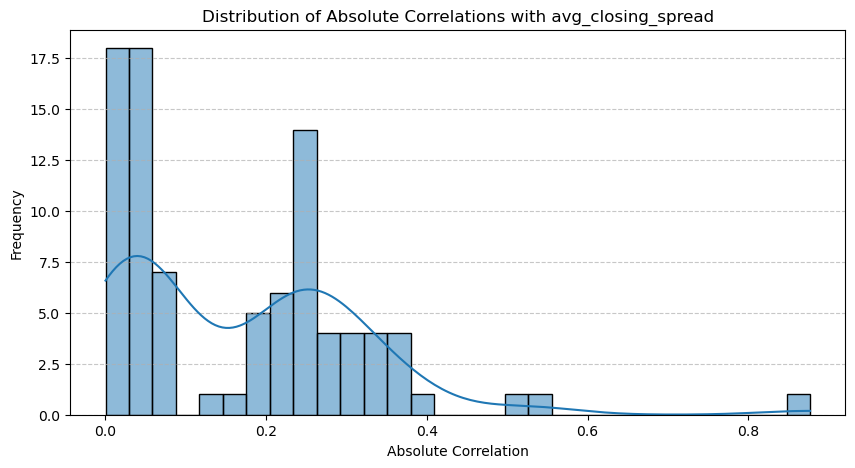


--- Analysis: Feature-Feature Correlation ---
Found 20 pairs with absolute correlation > 0.9

Highly Correlated Pairs (Feature1, Feature2, Correlation):
  - ('away_rp_percentPPA_Wk1_4' [0.049], 'away_rp_usage_Wk1_4' [0.051], 0.9798) -> Suggest dropping: 'away_rp_percentPPA_Wk1_4'
  - ('home_rp_percentPPA_Wk1_4' [0.073], 'home_rp_usage_Wk1_4' [0.077], 0.9788) -> Suggest dropping: 'home_rp_percentPPA_Wk1_4'
  - ('adj_hybrid_away_defense_standardDowns_successRate_ewma_lag1' [0.225], 'adj_hybrid_away_defense_successRate_ewma_lag1' [0.253], 0.9742) -> Suggest dropping: 'adj_hybrid_away_defense_standardDowns_successRate_ewma_lag1'
  - ('adj_hybrid_home_defense_standardDowns_successRate_ewma_lag1' [0.228], 'adj_hybrid_home_defense_successRate_ewma_lag1' [0.258], 0.9738) -> Suggest dropping: 'adj_hybrid_home_defense_standardDowns_successRate_ewma_lag1'
  - ('adj_hybrid_away_offense_standardDowns_successRate_ewma_lag1' [0.196], 'adj_hybrid_away_offense_successRate_ewma_lag1' [0.238], 0.9737) -

c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:20] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



Top 30 Features by XGBoost Importance (Gain):
                                              feature    importance
67                                      elo_diff_calc  19426.884766
68                              home_pregame_elo_calc   3668.238281
64                              away_pregame_elo_calc   3392.855469
22              adj_hybrid_away_offense_ppa_ewma_lag1    707.769897
61      adj_hybrid_home_offense_successRate_ewma_lag1    611.596191
54              adj_hybrid_home_offense_ppa_ewma_lag1    571.210083
14      adj_hybrid_away_defense_successRate_ewma_lag1    545.280457
27  adj_hybrid_away_offense_standardDowns_ppa_ewma...    496.848907
29      adj_hybrid_away_offense_successRate_ewma_lag1    492.368988
88                                             season    489.858490
46      adj_hybrid_home_defense_successRate_ewma_lag1    478.612152
39              adj_hybrid_home_defense_ppa_ewma_lag1    469.811401
12  adj_hybrid_away_defense_standardDowns_ppa_ewma...    443.560425
3

c:\Users\austi\Documents\Local Docs\github\BettingModels\Model_Functions.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')


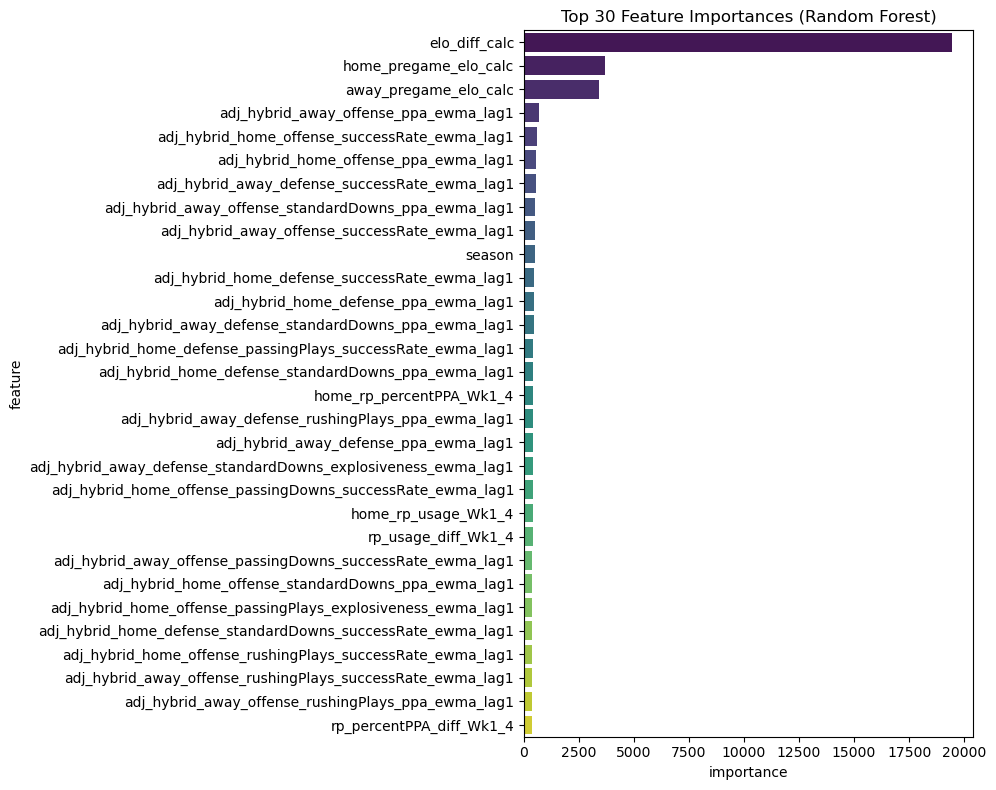


Features remaining after initial filtering & analysis: 90

--- Phase 2, Step 1 (Initial Analysis/Filtering) Complete ---

Defined 6 candidate feature sets:
  - A_Basic: 5 features
  - B_Top50_Corr: 50 features
  - C_Top50_RF_Importance: 50 features
  - D_Reduced_Correlation: 74 features
  - E_All_Initial_Filtered: 90 features
  - F_Top50_RF_plus_Basic: 51 features

--- Evaluating Feature Set: A_Basic (5 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:22] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for A_Basic: "['home_points', 'away_points', 'neutral_site', 'home_team', 'away_team'] not in index"
  RMSE: 6.1388, MAE: 4.8285, Correlation: 0.8958, Bias: 0.5243, Time: 0.5s

--- Evaluating Feature Set: B_Top50_Corr (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:22] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for B_Top50_Corr: "['home_points', 'away_points', 'neutral_site', 'home_team', 'away_team'] not in index"
  RMSE: 5.5240, MAE: 4.2968, Correlation: 0.9162, Bias: -0.2041, Time: 1.0s

--- Evaluating Feature Set: C_Top50_RF_Importance (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:23] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for C_Top50_RF_Importance: "['home_points', 'away_points', 'neutral_site', 'home_team', 'away_team'] not in index"
  RMSE: 5.5471, MAE: 4.2769, Correlation: 0.9155, Bias: 0.3312, Time: 1.4s

--- Evaluating Feature Set: D_Reduced_Correlation (74 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:25] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for D_Reduced_Correlation: "['home_points', 'away_points', 'neutral_site', 'home_team', 'away_team'] not in index"
  RMSE: 5.4886, MAE: 4.2455, Correlation: 0.9176, Bias: 0.4507, Time: 1.3s

--- Evaluating Feature Set: E_All_Initial_Filtered (90 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for E_All_Initial_Filtered: "['home_points', 'away_points', 'neutral_site', 'home_team', 'away_team'] not in index"
  RMSE: 5.4864, MAE: 4.2439, Correlation: 0.9174, Bias: 0.3138, Time: 1.9s

--- Evaluating Feature Set: F_Top50_RF_plus_Basic (51 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:28] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for F_Top50_RF_plus_Basic: "['home_points', 'away_points', 'neutral_site', 'home_team', 'away_team'] not in index"
  RMSE: 5.4734, MAE: 4.2023, Correlation: 0.9176, Bias: 0.2574, Time: 1.7s

--- Feature Set Evaluation Summary ---
              Set Name  Num Features   RMSE    MAE Correlation    Bias Betting Units Betting Win Rate Betting ROI Eval Time (s)
 F_Top50_RF_plus_Basic            51 5.4734 4.2023      0.9176  0.2574           nan             nan%        nan%           1.7
E_All_Initial_Filtered            90 5.4864 4.2439      0.9174  0.3138           nan             nan%        nan%           1.9
 D_Reduced_Correlation            74 5.4886 4.2455      0.9176  0.4507           nan             nan%        nan%           1.3
          B_Top50_Corr            50 5.5240 4.2968      0.9162 -0.2041           nan             nan%        nan%           1.0
 C_Top50_RF_Importance            50 5.5471 4.2769      0.9155  0.3312           nan             nan%   

In [9]:
# Pepare Data and do Temporal Split
y_train, X_train, y_val, X_val, X_train_analysis, X_val_analysis, val_df, train_df = MF.temporal_split(TRAIN_END_SEASON, VALIDATION_END_SEASON, master_df, target_variable, potential_features)
# Do Initial Filtering
current_features = MF.perform_initial_filtering(X_train_analysis, X_train, train_df)
# Perform the Correlation Analysis
features_to_consider_dropping_corr, correlations_abs = MF.perform_target_correlation_analysis(X_train_analysis, y_train, current_features, target_variable)
# Perform Model Based Importance Analysis
features_after_initial_analysis, feature_importance_df = MF.perform_model_based_importance(X_train, X_train_analysis, y_train, current_features)
# Define Candidate Feature Sets
candidate_feature_sets = MF.define_candidate_feature_sets(basic_features, features_after_initial_analysis, features_to_consider_dropping_corr, feature_importance_df, correlations_abs)
# Run Feature Set Evaluation
all_results = MF.run_feature_set_evaluation(candidate_feature_sets, XGB_PARAMS, NUM_BOOST_ROUNDS, X_train, y_train, X_val, y_val, val_df, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)
# Present Feature Set Evaluation Results
results_df = MF.present_feature_set_evaluation_results(all_results)

## Phase 3: Model Selection and Training

In [9]:
# Select Best Feature SEt
best_features = MF.select_best_feature_set(results_df, candidate_feature_sets, X_train, X_val)

Selected best feature set for tuning: 'E_All_Initial_Filtered' (92 features)
Using feature shapes: X_train_best=(5583, 92), X_val_best=(1467, 92)


In [10]:
# Run Optuna Study - LONG RUNNING CELL
study_hp = MF.run_optuna_study(X_train, X_val, y_train, y_val, val_df, best_features, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)

[I 2025-06-06 07:30:06,543] A new study created in memory with name: XGBoost Spread Prediction NaN



Starting Optuna hyperparameter search (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:06] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:19,179] Trial 0 finished with value: 5.574398368160954 and parameters: {'eta': 0.0684340562973679, 'max_depth': 9, 'subsample': 0.6070252585370408, 'colsample_bytree': 0.7399304847268791, 'min_child_weight': 1, 'gamma': 0.17035663697571646, 'lambda': 3.3435029432709985e-06, 'alpha': 0.0004382073496079546}. Best is trial 0 with value: 5.574398368160954.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:19] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:31,851] Trial 1 finished with value: 5.419439721637839 and parameters: {'eta': 0.03278893198451397, 'max_depth': 9, 'subsample': 0.8355737662697084, 'colsample_bytree': 0.920147510156657, 'min_child_weight': 7, 'gamma': 0.022919216201764403, 'lambda': 0.00020294060970884022, 'alpha': 5.947475191640867e-07}. Best is trial 1 with value: 5.419439721637839.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:36,634] Trial 2 finished with value: 5.49609068108458 and parameters: {'eta': 0.014809491328699792, 'max_depth': 6, 'subsample': 0.8039128051872415, 'colsample_bytree': 0.910359200776855, 'min_child_weight': 7, 'gamma': 0.3342384030792496, 'lambda': 8.221993611111295e-05, 'alpha': 0.05560831136896778}. Best is trial 1 with value: 5.419439721637839.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:36] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:37,404] Trial 3 finished with value: 5.517820400731199 and parameters: {'eta': 0.24210878419061302, 'max_depth': 3, 'subsample': 0.7212437459958583, 'colsample_bytree': 0.5746646488404024, 'min_child_weight': 9, 'gamma': 0.33008914287020413, 'lambda': 1.175788701107974e-06, 'alpha': 4.2000988651864105e-08}. Best is trial 1 with value: 5.419439721637839.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:37] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:40,713] Trial 4 finished with value: 5.354298624839182 and parameters: {'eta': 0.024088599995433054, 'max_depth': 5, 'subsample': 0.8012843502358891, 'colsample_bytree': 0.8213354418558594, 'min_child_weight': 9, 'gamma': 0.31632506577109304, 'lambda': 0.2966781216046384, 'alpha': 8.664675014597541e-08}. Best is trial 4 with value: 5.354298624839182.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:41,513] Trial 5 finished with value: 5.712166652797512 and parameters: {'eta': 0.26487368553977586, 'max_depth': 6, 'subsample': 0.9674727814895565, 'colsample_bytree': 0.7369682920447485, 'min_child_weight': 6, 'gamma': 0.05550433461531662, 'lambda': 0.00012279550171951224, 'alpha': 0.0022450603905835526}. Best is trial 4 with value: 5.354298624839182.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:42,766] Trial 6 finished with value: 5.687026746525511 and parameters: {'eta': 0.01944307412347125, 'max_depth': 3, 'subsample': 0.8350550036803901, 'colsample_bytree': 0.5999228018481519, 'min_child_weight': 3, 'gamma': 0.4966654497172469, 'lambda': 0.0004527197345927357, 'alpha': 1.8985275590852285e-05}. Best is trial 4 with value: 5.354298624839182.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:42] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:47,432] Trial 7 finished with value: 5.338330166143691 and parameters: {'eta': 0.0352408682976616, 'max_depth': 7, 'subsample': 0.540062315504916, 'colsample_bytree': 0.8583039836592221, 'min_child_weight': 6, 'gamma': 0.2375372176090006, 'lambda': 0.09792994255879775, 'alpha': 0.002160918693697252}. Best is trial 7 with value: 5.338330166143691.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:47] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:49,251] Trial 8 finished with value: 5.370000952246302 and parameters: {'eta': 0.0781026987395518, 'max_depth': 5, 'subsample': 0.7836847652045594, 'colsample_bytree': 0.7570796800482814, 'min_child_weight': 9, 'gamma': 0.4002650457291074, 'lambda': 6.602983473655822e-08, 'alpha': 3.090551288813862e-08}. Best is trial 7 with value: 5.338330166143691.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:49] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:53,161] Trial 9 finished with value: 5.495904392794571 and parameters: {'eta': 0.07370891445647546, 'max_depth': 8, 'subsample': 0.9981517325636113, 'colsample_bytree': 0.5475552595091548, 'min_child_weight': 6, 'gamma': 0.2125373267588212, 'lambda': 3.401968979629833e-05, 'alpha': 1.3102956279490383e-06}. Best is trial 7 with value: 5.338330166143691.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:54,888] Trial 10 finished with value: 5.5456584076524695 and parameters: {'eta': 0.135795576675908, 'max_depth': 7, 'subsample': 0.5059292248024694, 'colsample_bytree': 0.9681859872499987, 'min_child_weight': 4, 'gamma': 0.15184654644224277, 'lambda': 0.8700996141700241, 'alpha': 0.2134320351042967}. Best is trial 7 with value: 5.338330166143691.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:55] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:57,418] Trial 11 finished with value: 5.297128064000625 and parameters: {'eta': 0.030830821140161405, 'max_depth': 5, 'subsample': 0.692210764951563, 'colsample_bytree': 0.8214315842772971, 'min_child_weight': 10, 'gamma': 0.2867463463703197, 'lambda': 0.5883666356002106, 'alpha': 0.00977711058224662}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:30:57] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:30:59,954] Trial 12 finished with value: 5.332205513448566 and parameters: {'eta': 0.0354336397038196, 'max_depth': 5, 'subsample': 0.6194559769428348, 'colsample_bytree': 0.8463645012748693, 'min_child_weight': 10, 'gamma': 0.25644394044724217, 'lambda': 0.017811582829576598, 'alpha': 0.013117059558011308}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:00] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:02,068] Trial 13 finished with value: 6.093943349943076 and parameters: {'eta': 0.010262014959876106, 'max_depth': 4, 'subsample': 0.6780405960998458, 'colsample_bytree': 0.6573045006610494, 'min_child_weight': 10, 'gamma': 0.11006484534895955, 'lambda': 0.011200252534017067, 'alpha': 0.020394469317712015}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:02] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:04,526] Trial 14 finished with value: 5.31588117253491 and parameters: {'eta': 0.04235690079201993, 'max_depth': 5, 'subsample': 0.6236985003826033, 'colsample_bytree': 0.8208206333875523, 'min_child_weight': 10, 'gamma': 0.27378090267683064, 'lambda': 0.010909514371587992, 'alpha': 0.6002531026005489}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:04] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:06,305] Trial 15 finished with value: 5.321834592810242 and parameters: {'eta': 0.0454817142838214, 'max_depth': 4, 'subsample': 0.6487685770182323, 'colsample_bytree': 0.6780113790836868, 'min_child_weight': 8, 'gamma': 0.4119025690961098, 'lambda': 0.004248990925170345, 'alpha': 0.7150439198747308}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:06] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:08,016] Trial 16 finished with value: 5.4359034455925785 and parameters: {'eta': 0.10551661668802598, 'max_depth': 6, 'subsample': 0.7152630325108698, 'colsample_bytree': 0.7863534725855421, 'min_child_weight': 4, 'gamma': 0.2759681232648992, 'lambda': 0.002075952032925995, 'alpha': 0.8546037169093189}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:08] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:10,089] Trial 17 finished with value: 5.406522433522091 and parameters: {'eta': 0.022961239725901767, 'max_depth': 4, 'subsample': 0.5698687439722919, 'colsample_bytree': 0.9940368170599247, 'min_child_weight': 10, 'gamma': 0.41001887669894815, 'lambda': 0.059628559451910396, 'alpha': 7.302393581252649e-05}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:10] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:13,976] Trial 18 finished with value: 5.397806073331181 and parameters: {'eta': 0.05086618338477425, 'max_depth': 7, 'subsample': 0.6865136635978181, 'colsample_bytree': 0.8984961392615167, 'min_child_weight': 8, 'gamma': 0.1893908278116179, 'lambda': 0.13440849683006037, 'alpha': 0.09409555844313608}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:14] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:14,984] Trial 19 finished with value: 5.416028036307671 and parameters: {'eta': 0.13337448452626216, 'max_depth': 5, 'subsample': 0.9135051098449759, 'colsample_bytree': 0.6817245452437654, 'min_child_weight': 8, 'gamma': 0.11541038932343584, 'lambda': 0.0015292837781194176, 'alpha': 0.0060272041417438246}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:15] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:16,932] Trial 20 finished with value: 5.564878353374146 and parameters: {'eta': 0.016684981630118282, 'max_depth': 4, 'subsample': 0.5866327415450668, 'colsample_bytree': 0.8009021504915151, 'min_child_weight': 2, 'gamma': 0.2879717764741446, 'lambda': 0.02113317363036551, 'alpha': 0.00042492708908481664}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:17] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:18,811] Trial 21 finished with value: 5.2971937679045915 and parameters: {'eta': 0.0462249736389225, 'max_depth': 4, 'subsample': 0.6633793013872008, 'colsample_bytree': 0.7013905637388591, 'min_child_weight': 8, 'gamma': 0.40459921628083234, 'lambda': 0.003624611241945207, 'alpha': 0.77227585549988}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:18] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:20,163] Trial 22 finished with value: 5.51581504479109 and parameters: {'eta': 0.02879987493183077, 'max_depth': 3, 'subsample': 0.6553617591191518, 'colsample_bytree': 0.7138613498492746, 'min_child_weight': 10, 'gamma': 0.49583764698871413, 'lambda': 0.36148552649507176, 'alpha': 0.2821041024006892}. Best is trial 11 with value: 5.297128064000625.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:20] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:22,563] Trial 23 finished with value: 5.245912829507409 and parameters: {'eta': 0.043007237597148876, 'max_depth': 5, 'subsample': 0.740990201082724, 'colsample_bytree': 0.6394172621795343, 'min_child_weight': 9, 'gamma': 0.4439167846467735, 'lambda': 0.0007877205421020262, 'alpha': 0.053736847124050836}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:22] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:24,339] Trial 24 finished with value: 5.332416649068477 and parameters: {'eta': 0.06598034609146476, 'max_depth': 4, 'subsample': 0.7438595120739468, 'colsample_bytree': 0.6256843952393883, 'min_child_weight': 7, 'gamma': 0.45777082413920545, 'lambda': 2.2531639583119273e-05, 'alpha': 0.03683627703848034}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:25,919] Trial 25 finished with value: 5.285237590651732 and parameters: {'eta': 0.05422072496704018, 'max_depth': 5, 'subsample': 0.755472583716402, 'colsample_bytree': 0.5029713212950926, 'min_child_weight': 9, 'gamma': 0.3687571604214332, 'lambda': 0.000856177716665494, 'alpha': 0.1137453114150156}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:27,192] Trial 26 finished with value: 5.403811667175192 and parameters: {'eta': 0.10019281615115953, 'max_depth': 6, 'subsample': 0.7660936374886914, 'colsample_bytree': 0.518867778461742, 'min_child_weight': 9, 'gamma': 0.3619251646171514, 'lambda': 5.04482979806846e-06, 'alpha': 0.005130704906843299}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:27] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:29,418] Trial 27 finished with value: 5.320148833092101 and parameters: {'eta': 0.05815675909506359, 'max_depth': 5, 'subsample': 0.8811904394790651, 'colsample_bytree': 0.5173300200879711, 'min_child_weight': 9, 'gamma': 0.3565297661328488, 'lambda': 0.0006123234757280335, 'alpha': 0.0006671809537567895}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:29] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:32,507] Trial 28 finished with value: 5.291917232572903 and parameters: {'eta': 0.02959699708869715, 'max_depth': 6, 'subsample': 0.7214584648000403, 'colsample_bytree': 0.6242950541557011, 'min_child_weight': 8, 'gamma': 0.4593313731033007, 'lambda': 1.3135409398651058e-08, 'alpha': 0.11212123886914459}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:32] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:37,823] Trial 29 finished with value: 5.62606971050378 and parameters: {'eta': 0.012728106054358122, 'max_depth': 7, 'subsample': 0.7461649268981356, 'colsample_bytree': 0.5685394664752144, 'min_child_weight': 5, 'gamma': 0.4360764622018365, 'lambda': 4.802270099899392e-08, 'alpha': 0.09383057161382201}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:37] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:46,816] Trial 30 finished with value: 5.4097894194277325 and parameters: {'eta': 0.023896428398341753, 'max_depth': 8, 'subsample': 0.8447769169505808, 'colsample_bytree': 0.6393872787796359, 'min_child_weight': 1, 'gamma': 0.45799441000292834, 'lambda': 2.9070695937746517e-07, 'alpha': 3.6643660228396e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:46] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:50,124] Trial 31 finished with value: 5.334573587407744 and parameters: {'eta': 0.02920316596114435, 'max_depth': 6, 'subsample': 0.6984976666704619, 'colsample_bytree': 0.6200825505414617, 'min_child_weight': 8, 'gamma': 0.3684607705381243, 'lambda': 3.6491415500903887e-06, 'alpha': 0.14734043844236155}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:53,200] Trial 32 finished with value: 5.290649295156655 and parameters: {'eta': 0.03923175675631973, 'max_depth': 6, 'subsample': 0.7351063161594826, 'colsample_bytree': 0.5937471095780887, 'min_child_weight': 9, 'gamma': 0.45511263221516846, 'lambda': 1.2179978313573538e-08, 'alpha': 0.017703872669534552}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:56,220] Trial 33 finished with value: 5.314666574129709 and parameters: {'eta': 0.03723724393089397, 'max_depth': 6, 'subsample': 0.7387762223282033, 'colsample_bytree': 0.5926162438186272, 'min_child_weight': 7, 'gamma': 0.4659409505237205, 'lambda': 1.2935923733749488e-07, 'alpha': 0.03455384955172354}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:56] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:31:59,815] Trial 34 finished with value: 5.381688994564391 and parameters: {'eta': 0.05748014310066762, 'max_depth': 8, 'subsample': 0.777046914546093, 'colsample_bytree': 0.5463451388564929, 'min_child_weight': 9, 'gamma': 0.4342214942211662, 'lambda': 3.779596084344091e-07, 'alpha': 0.000499779998508911}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:31:59] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:01,625] Trial 35 finished with value: 5.425645870651075 and parameters: {'eta': 0.09138993129610319, 'max_depth': 6, 'subsample': 0.8326890493684915, 'colsample_bytree': 0.5419885035437857, 'min_child_weight': 7, 'gamma': 0.3839156501711425, 'lambda': 1.1001357894610798e-08, 'alpha': 0.04956526587186298}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:01] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:05,459] Trial 36 finished with value: 5.337287585932859 and parameters: {'eta': 0.04040790487336837, 'max_depth': 7, 'subsample': 0.7170009119660358, 'colsample_bytree': 0.5098559773603099, 'min_child_weight': 9, 'gamma': 0.474990472266342, 'lambda': 1.1328107908110956e-08, 'alpha': 0.0026503058429827417}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:08,173] Trial 37 finished with value: 5.406421193896536 and parameters: {'eta': 0.019710751360439437, 'max_depth': 5, 'subsample': 0.795977376685482, 'colsample_bytree': 0.5891356734645914, 'min_child_weight': 7, 'gamma': 0.3165996699793532, 'lambda': 0.00035191000011241093, 'alpha': 0.19946842164536974}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:08] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:10,466] Trial 38 finished with value: 5.306187203482344 and parameters: {'eta': 0.06093747349916064, 'max_depth': 6, 'subsample': 0.8139409275061691, 'colsample_bytree': 0.6387430260371911, 'min_child_weight': 8, 'gamma': 0.4357780500661534, 'lambda': 4.5456783399108604e-05, 'alpha': 0.023396500456333263}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:10] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:12,393] Trial 39 finished with value: 5.679485018201726 and parameters: {'eta': 0.20414772833012065, 'max_depth': 9, 'subsample': 0.7649392934752386, 'colsample_bytree': 0.566303783426562, 'min_child_weight': 9, 'gamma': 0.3361269100459392, 'lambda': 8.741668170897024e-06, 'alpha': 1.5252606110774838e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:12] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:14,817] Trial 40 finished with value: 5.333118048588358 and parameters: {'eta': 0.04855103137431755, 'max_depth': 5, 'subsample': 0.9000905034955209, 'colsample_bytree': 0.6011135862706021, 'min_child_weight': 9, 'gamma': 0.4955417861569093, 'lambda': 1.5383754218559878e-06, 'alpha': 1.1375295586248524e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:14] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:17,487] Trial 41 finished with value: 5.312878387731638 and parameters: {'eta': 0.029812020851958804, 'max_depth': 5, 'subsample': 0.7104751265696223, 'colsample_bytree': 0.7274551143469223, 'min_child_weight': 10, 'gamma': 0.38486480594828426, 'lambda': 2.5502443063527452e-08, 'alpha': 0.009377095132612059}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:17] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:19,854] Trial 42 finished with value: 5.315597263620588 and parameters: {'eta': 0.0313620621046925, 'max_depth': 5, 'subsample': 0.728715419824931, 'colsample_bytree': 0.6548616364379005, 'min_child_weight': 10, 'gamma': 0.43106754254478674, 'lambda': 0.00014232830703824305, 'alpha': 0.07027735843458872}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:19] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:23,848] Trial 43 finished with value: 5.319718133368402 and parameters: {'eta': 0.026025900055919246, 'max_depth': 6, 'subsample': 0.6375104963784107, 'colsample_bytree': 0.7593525665529257, 'min_child_weight': 8, 'gamma': 0.30776061496728546, 'lambda': 0.0009753484552580713, 'alpha': 0.002510997370096313}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:28,032] Trial 44 finished with value: 5.345363087424247 and parameters: {'eta': 0.020754569052056207, 'max_depth': 6, 'subsample': 0.6757876802190421, 'colsample_bytree': 0.8836801619147592, 'min_child_weight': 9, 'gamma': 0.33975797663646057, 'lambda': 3.041964212299285e-07, 'alpha': 0.26070916891618917}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:28] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:30,990] Trial 45 finished with value: 5.290806437962106 and parameters: {'eta': 0.037339194955034134, 'max_depth': 5, 'subsample': 0.7020702701444952, 'colsample_bytree': 0.9376811962272286, 'min_child_weight': 10, 'gamma': 0.3817026558748971, 'lambda': 3.648046081315071e-08, 'alpha': 0.012610996647491799}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:33,696] Trial 46 finished with value: 5.364746020714151 and parameters: {'eta': 0.07341337955311501, 'max_depth': 6, 'subsample': 0.7623766637168549, 'colsample_bytree': 0.9567334124191617, 'min_child_weight': 9, 'gamma': 0.47369807382525897, 'lambda': 4.752388090013133e-08, 'alpha': 0.00126414041474612}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:33] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:36,377] Trial 47 finished with value: 5.292886308287462 and parameters: {'eta': 0.03703526695861512, 'max_depth': 5, 'subsample': 0.7883514474852147, 'colsample_bytree': 0.6103144781899873, 'min_child_weight': 10, 'gamma': 0.3901874687853506, 'lambda': 2.2805610750231167e-08, 'alpha': 0.0001660499775548499}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:36] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:41,006] Trial 48 finished with value: 5.325350144803642 and parameters: {'eta': 0.041513529279693, 'max_depth': 7, 'subsample': 0.8171955439617358, 'colsample_bytree': 0.6848718422570235, 'min_child_weight': 5, 'gamma': 0.4498384078144474, 'lambda': 8.523724183383817e-08, 'alpha': 0.012203147319207013}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:42,346] Trial 49 finished with value: 5.386165093963451 and parameters: {'eta': 0.052116591353084205, 'max_depth': 3, 'subsample': 0.8571582014829834, 'colsample_bytree': 0.5744260034497531, 'min_child_weight': 6, 'gamma': 0.4181907671990638, 'lambda': 7.283200540536954e-07, 'alpha': 0.019678694939607912}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:42] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:44,059] Trial 50 finished with value: 5.310076188942929 and parameters: {'eta': 0.035303446192093274, 'max_depth': 4, 'subsample': 0.7274911859850993, 'colsample_bytree': 0.5498711581752588, 'min_child_weight': 8, 'gamma': 0.035063695385994686, 'lambda': 0.0002492863181848732, 'alpha': 0.41877241162208606}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:44] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:46,170] Trial 51 finished with value: 5.2490871312200085 and parameters: {'eta': 0.03843619942767024, 'max_depth': 5, 'subsample': 0.78108654406007, 'colsample_bytree': 0.6091543102877209, 'min_child_weight': 10, 'gamma': 0.38504892888408915, 'lambda': 1.524263305721198e-08, 'alpha': 1.3981989350620556e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:46] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:48,662] Trial 52 finished with value: 5.297954914808 and parameters: {'eta': 0.027139251351091655, 'max_depth': 5, 'subsample': 0.6981692411417599, 'colsample_bytree': 0.6688622127222532, 'min_child_weight': 10, 'gamma': 0.36877326835678204, 'lambda': 2.3317462866577446e-08, 'alpha': 7.280506487959108e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:48] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:50,624] Trial 53 finished with value: 5.356473920375754 and parameters: {'eta': 0.0827785537415216, 'max_depth': 6, 'subsample': 0.7506912750878925, 'colsample_bytree': 0.6458675662044953, 'min_child_weight': 9, 'gamma': 0.42153840174114127, 'lambda': 1.3675078853910442e-07, 'alpha': 9.913811920981678e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:52,882] Trial 54 finished with value: 5.284965902989079 and parameters: {'eta': 0.041359582667716985, 'max_depth': 5, 'subsample': 0.7762147630575392, 'colsample_bytree': 0.5318580668710156, 'min_child_weight': 10, 'gamma': 0.44721826989799945, 'lambda': 1.1445934893529846e-08, 'alpha': 1.7932961596246632e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:54,570] Trial 55 finished with value: 5.316030709686246 and parameters: {'eta': 0.04361193693638988, 'max_depth': 4, 'subsample': 0.7802822988966877, 'colsample_bytree': 0.5235180109152762, 'min_child_weight': 10, 'gamma': 0.39775460376969696, 'lambda': 3.952566195868167e-08, 'alpha': 1.4774161480978021e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:54] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:56,056] Trial 56 finished with value: 5.364031868743693 and parameters: {'eta': 0.06650599437424312, 'max_depth': 5, 'subsample': 0.814491510261357, 'colsample_bytree': 0.5288765142586873, 'min_child_weight': 10, 'gamma': 0.4765650597425917, 'lambda': 1.2221398309438713e-07, 'alpha': 2.8155351535981994e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:56] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:32:57,537] Trial 57 finished with value: 5.2916714644858285 and parameters: {'eta': 0.050871525414917365, 'max_depth': 4, 'subsample': 0.7982675359871467, 'colsample_bytree': 0.500986331603826, 'min_child_weight': 10, 'gamma': 0.443515344970784, 'lambda': 6.29237502223526e-05, 'alpha': 2.0744514739338364e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:57] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:00,539] Trial 58 finished with value: 5.283640229723061 and parameters: {'eta': 0.033630059601134236, 'max_depth': 5, 'subsample': 0.7593189787494803, 'colsample_bytree': 0.9328228460986688, 'min_child_weight': 9, 'gamma': 0.22574788764421075, 'lambda': 2.6441695077020727e-08, 'alpha': 3.7451939460181666e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:00] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:03,051] Trial 59 finished with value: 5.4831094142378785 and parameters: {'eta': 0.01656042769125555, 'max_depth': 5, 'subsample': 0.8643508624352757, 'colsample_bytree': 0.5638668988117523, 'min_child_weight': 9, 'gamma': 0.193104731295045, 'lambda': 0.0063417785304462435, 'alpha': 6.215761301769239e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:03] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:05,713] Trial 60 finished with value: 5.337730159388024 and parameters: {'eta': 0.045957293312221065, 'max_depth': 4, 'subsample': 0.7567097576466357, 'colsample_bytree': 0.5910561858253007, 'min_child_weight': 9, 'gamma': 0.21378502259626095, 'lambda': 1.6356553875474837e-08, 'alpha': 1.9778532083428628e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:08,936] Trial 61 finished with value: 5.295719409063268 and parameters: {'eta': 0.033597706670179014, 'max_depth': 5, 'subsample': 0.779388914691924, 'colsample_bytree': 0.9537517345614241, 'min_child_weight': 10, 'gamma': 0.3486371575924379, 'lambda': 3.325689607435138e-08, 'alpha': 1.2876624651944616e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:09] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:11,742] Trial 62 finished with value: 5.2795919497919455 and parameters: {'eta': 0.04066381353893832, 'max_depth': 5, 'subsample': 0.7420856681070371, 'colsample_bytree': 0.991502559456949, 'min_child_weight': 10, 'gamma': 0.25564436633221244, 'lambda': 7.200023850935762e-08, 'alpha': 2.708425224866449e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:11] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:14,823] Trial 63 finished with value: 5.2758435678791615 and parameters: {'eta': 0.040883341220322694, 'max_depth': 5, 'subsample': 0.8315198915767847, 'colsample_bytree': 0.9974247722772571, 'min_child_weight': 9, 'gamma': 0.10940574365933553, 'lambda': 7.763506745298616e-08, 'alpha': 2.290421850571614e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:14] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:16,789] Trial 64 finished with value: 5.336606749250524 and parameters: {'eta': 0.06099524647380952, 'max_depth': 5, 'subsample': 0.8288046281323844, 'colsample_bytree': 0.9873433977107607, 'min_child_weight': 10, 'gamma': 0.14259847146145294, 'lambda': 6.141048519348429e-08, 'alpha': 2.6571515972035245e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:16] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:19,397] Trial 65 finished with value: 5.345593893718437 and parameters: {'eta': 0.055049152835541154, 'max_depth': 5, 'subsample': 0.8020638157264413, 'colsample_bytree': 0.9835074953881003, 'min_child_weight': 9, 'gamma': 0.06664923134297213, 'lambda': 0.0007404713469248244, 'alpha': 3.8512266711852685e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:19] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:21,308] Trial 66 finished with value: 5.353215074693056 and parameters: {'eta': 0.032154763582721034, 'max_depth': 4, 'subsample': 0.8478077864444515, 'colsample_bytree': 0.9221727705712991, 'min_child_weight': 3, 'gamma': 0.24576118628947824, 'lambda': 0.0014988351504020571, 'alpha': 2.848324958965684e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:21] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:23,905] Trial 67 finished with value: 5.316064655034039 and parameters: {'eta': 0.04384369085438081, 'max_depth': 5, 'subsample': 0.7683884163609822, 'colsample_bytree': 0.9763820040321012, 'min_child_weight': 8, 'gamma': 0.11447248807174311, 'lambda': 8.572282442941188e-07, 'alpha': 4.96949588325837e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:26,169] Trial 68 finished with value: 5.400673176425226 and parameters: {'eta': 0.025497548326886863, 'max_depth': 4, 'subsample': 0.7498730867564218, 'colsample_bytree': 0.9642833239914792, 'min_child_weight': 10, 'gamma': 0.2213990470248231, 'lambda': 1.8560520527298046e-07, 'alpha': 5.039083064095682e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:28,939] Trial 69 finished with value: 5.280267707409931 and parameters: {'eta': 0.050392610465290914, 'max_depth': 5, 'subsample': 0.678380910671041, 'colsample_bytree': 0.9291807287349373, 'min_child_weight': 9, 'gamma': 0.2631624107342429, 'lambda': 7.912170396347497e-08, 'alpha': 1.096363299714873e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:29] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:32,188] Trial 70 finished with value: 5.37532245857127 and parameters: {'eta': 0.02237315399234939, 'max_depth': 5, 'subsample': 0.9429302117819609, 'colsample_bytree': 0.8591396624523301, 'min_child_weight': 9, 'gamma': 0.15526115131642315, 'lambda': 7.942706675501723e-08, 'alpha': 1.4441580897680933e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:32] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:36,160] Trial 71 finished with value: 5.320996431340411 and parameters: {'eta': 0.04913721876546042, 'max_depth': 5, 'subsample': 0.7384927441074521, 'colsample_bytree': 0.9166837803541914, 'min_child_weight': 9, 'gamma': 0.2581844245691246, 'lambda': 4.2339488068907735e-07, 'alpha': 9.704311241967554e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:36] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:39,700] Trial 72 finished with value: 5.307190472154219 and parameters: {'eta': 0.034100827258535985, 'max_depth': 5, 'subsample': 0.6651371629404115, 'colsample_bytree': 0.9990613830205186, 'min_child_weight': 8, 'gamma': 0.08611934770065602, 'lambda': 1.9731512449616484e-07, 'alpha': 3.8480104467315824e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:39] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:42,520] Trial 73 finished with value: 5.2717956272064 and parameters: {'eta': 0.040308748481172614, 'max_depth': 5, 'subsample': 0.8208799340480493, 'colsample_bytree': 0.9388084052524807, 'min_child_weight': 10, 'gamma': 0.29754134303090607, 'lambda': 1.627243126794051e-06, 'alpha': 8.251450527795777e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:42] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:45,056] Trial 74 finished with value: 5.317336287040344 and parameters: {'eta': 0.044769689616029826, 'max_depth': 5, 'subsample': 0.5986014679508507, 'colsample_bytree': 0.9504670739114959, 'min_child_weight': 10, 'gamma': 0.3006013045054203, 'lambda': 1.783578053187528e-06, 'alpha': 7.699294941687372e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:45] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:47,920] Trial 75 finished with value: 5.286409074728216 and parameters: {'eta': 0.03988766839903644, 'max_depth': 5, 'subsample': 0.8202121028656572, 'colsample_bytree': 0.9356865781696037, 'min_child_weight': 10, 'gamma': 0.26776026341899756, 'lambda': 2.007960295022761e-08, 'alpha': 1.423018390431346e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:48] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:49,969] Trial 76 finished with value: 5.32685538392791 and parameters: {'eta': 0.03932808781513412, 'max_depth': 4, 'subsample': 0.7928706970099505, 'colsample_bytree': 0.8958729150965015, 'min_child_weight': 10, 'gamma': 0.006286499051294414, 'lambda': 9.210179493733074e-08, 'alpha': 2.513044126766568e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:53,248] Trial 77 finished with value: 5.343116662119517 and parameters: {'eta': 0.03376669499204168, 'max_depth': 5, 'subsample': 0.8816153426453501, 'colsample_bytree': 0.9707598489679496, 'min_child_weight': 9, 'gamma': 0.2299100554724903, 'lambda': 5.23109984879034e-08, 'alpha': 3.6321747483687016e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:55,328] Trial 78 finished with value: 5.311189799407566 and parameters: {'eta': 0.0485701363444876, 'max_depth': 4, 'subsample': 0.8375293575834638, 'colsample_bytree': 0.880536388355839, 'min_child_weight': 10, 'gamma': 0.19410495393128122, 'lambda': 2.5465588417193375e-05, 'alpha': 1.218908559901513e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:55] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:33:58,119] Trial 79 finished with value: 5.389587199457678 and parameters: {'eta': 0.060575017359000005, 'max_depth': 6, 'subsample': 0.6838403974391312, 'colsample_bytree': 0.9248378519788081, 'min_child_weight': 8, 'gamma': 0.28580004516699414, 'lambda': 4.907480349197337e-07, 'alpha': 8.920701852653106e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:33:58] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:00,248] Trial 80 finished with value: 5.347938754459853 and parameters: {'eta': 0.07334794894731869, 'max_depth': 5, 'subsample': 0.8076657633731532, 'colsample_bytree': 0.9426804949537249, 'min_child_weight': 9, 'gamma': 0.2495974575343736, 'lambda': 2.129149935849881e-07, 'alpha': 4.9924798172120675e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:00] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:02,821] Trial 81 finished with value: 5.301707778752708 and parameters: {'eta': 0.0554276794976841, 'max_depth': 5, 'subsample': 0.7711033095874512, 'colsample_bytree': 0.8372155007132256, 'min_child_weight': 9, 'gamma': 0.3232006682338566, 'lambda': 0.0028536801995052256, 'alpha': 8.045676547848497e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:02] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:05,420] Trial 82 finished with value: 5.31195672586232 and parameters: {'eta': 0.04283377146040884, 'max_depth': 5, 'subsample': 0.7875166861418614, 'colsample_bytree': 0.7732663798532566, 'min_child_weight': 10, 'gamma': 0.2755626628904934, 'lambda': 8.618856484836883e-06, 'alpha': 2.1295925808888074e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:08,568] Trial 83 finished with value: 5.312002297532572 and parameters: {'eta': 0.027695403671876003, 'max_depth': 5, 'subsample': 0.7152436014645892, 'colsample_bytree': 0.9089544503653864, 'min_child_weight': 9, 'gamma': 0.3074567538648223, 'lambda': 1.0390810014389683e-08, 'alpha': 2.647238710189271e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:08] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:11,538] Trial 84 finished with value: 5.30197261919397 and parameters: {'eta': 0.036795165959333874, 'max_depth': 6, 'subsample': 0.7607015510014401, 'colsample_bytree': 0.5352623875228335, 'min_child_weight': 10, 'gamma': 0.2357338652187177, 'lambda': 0.00012016714361983963, 'alpha': 1.1131561661409361e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:11] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:13,885] Trial 85 finished with value: 5.3119780351368 and parameters: {'eta': 0.05253240591447341, 'max_depth': 5, 'subsample': 0.7326618784820005, 'colsample_bytree': 0.9994475618842077, 'min_child_weight': 9, 'gamma': 0.29194715366892565, 'lambda': 2.987065643170356e-08, 'alpha': 4.021430604460557e-07}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:14] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:17,124] Trial 86 finished with value: 5.343779671125307 and parameters: {'eta': 0.0318442800683926, 'max_depth': 5, 'subsample': 0.8648709270684437, 'colsample_bytree': 0.9810317004346386, 'min_child_weight': 8, 'gamma': 0.16781867935868877, 'lambda': 1.9930047098823935e-08, 'alpha': 2.926748808507891e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:17] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:18,480] Trial 87 finished with value: 5.324213151694498 and parameters: {'eta': 0.06539547906091789, 'max_depth': 5, 'subsample': 0.8267618259430735, 'colsample_bytree': 0.5019990498996556, 'min_child_weight': 9, 'gamma': 0.26067242796034273, 'lambda': 0.0005122911327159162, 'alpha': 4.499501242554422e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:18] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:20,326] Trial 88 finished with value: 5.312207519837689 and parameters: {'eta': 0.039531409537389886, 'max_depth': 4, 'subsample': 0.6349171086658036, 'colsample_bytree': 0.5566368488600829, 'min_child_weight': 7, 'gamma': 0.37348606527773465, 'lambda': 6.868829104957191e-08, 'alpha': 7.28379212085255e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:20] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:23,903] Trial 89 finished with value: 5.30310374640023 and parameters: {'eta': 0.04666549001942727, 'max_depth': 6, 'subsample': 0.5041854094469098, 'colsample_bytree': 0.9678098794486759, 'min_child_weight': 10, 'gamma': 0.3289969035039932, 'lambda': 0.03944871092606191, 'alpha': 1.8843905477177297e-08}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:26,534] Trial 90 finished with value: 5.2937397052479405 and parameters: {'eta': 0.03643112579931127, 'max_depth': 5, 'subsample': 0.7464419928861605, 'colsample_bytree': 0.6976764002637253, 'min_child_weight': 4, 'gamma': 0.20205055153979645, 'lambda': 0.00021540831210329134, 'alpha': 2.0110693971581618e-06}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:29,569] Trial 91 finished with value: 5.283465118345279 and parameters: {'eta': 0.04211935551684747, 'max_depth': 5, 'subsample': 0.8172951883890629, 'colsample_bytree': 0.9384209338918442, 'min_child_weight': 10, 'gamma': 0.25955807906865636, 'lambda': 1.5480945182777313e-08, 'alpha': 8.992408001450843e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:29] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:31,887] Trial 92 finished with value: 5.282835707281735 and parameters: {'eta': 0.04263462704175496, 'max_depth': 5, 'subsample': 0.5432049879883295, 'colsample_bytree': 0.932633622387832, 'min_child_weight': 10, 'gamma': 0.24598925272146013, 'lambda': 1.5842742642664996e-08, 'alpha': 7.998540625075714e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:32] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:34,519] Trial 93 finished with value: 5.299644837401091 and parameters: {'eta': 0.042897774227788364, 'max_depth': 5, 'subsample': 0.5423434039711141, 'colsample_bytree': 0.9021043179081578, 'min_child_weight': 10, 'gamma': 0.22645480562717732, 'lambda': 1.7801462197440624e-08, 'alpha': 2.3153823720415685e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:34] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:37,496] Trial 94 finished with value: 5.2967289958181825 and parameters: {'eta': 0.030259395866627112, 'max_depth': 5, 'subsample': 0.8095151156432293, 'colsample_bytree': 0.9303516736033629, 'min_child_weight': 10, 'gamma': 0.24828780540797452, 'lambda': 1.0122167477413622e-08, 'alpha': 7.391941243875342e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:37] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:40,287] Trial 95 finished with value: 5.327361824022591 and parameters: {'eta': 0.04774451198848045, 'max_depth': 6, 'subsample': 0.5317414451463526, 'colsample_bytree': 0.8852585470554057, 'min_child_weight': 10, 'gamma': 0.20569360356511315, 'lambda': 3.1320618962536706e-08, 'alpha': 0.00018508198514415223}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:42,949] Trial 96 finished with value: 5.300880312557422 and parameters: {'eta': 0.040515148698848, 'max_depth': 5, 'subsample': 0.8504204881154638, 'colsample_bytree': 0.9475359032749541, 'min_child_weight': 10, 'gamma': 0.1757706311832572, 'lambda': 1.5668221614193803e-08, 'alpha': 1.43182226711407e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:43] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:45,181] Trial 97 finished with value: 5.328102905565211 and parameters: {'eta': 0.03591038962485773, 'max_depth': 4, 'subsample': 0.8769435305327578, 'colsample_bytree': 0.8606786805499186, 'min_child_weight': 10, 'gamma': 0.2715490500483262, 'lambda': 1.1945239751808118e-07, 'alpha': 4.724108361309156e-05}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:45] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:47,004] Trial 98 finished with value: 5.3405096230242615 and parameters: {'eta': 0.05207158135129503, 'max_depth': 5, 'subsample': 0.570513729524297, 'colsample_bytree': 0.7412999882326158, 'min_child_weight': 9, 'gamma': 0.23828348654500425, 'lambda': 4.383863747625485e-08, 'alpha': 0.00021912144514099136}. Best is trial 23 with value: 5.245912829507409.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:34:47] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-06 07:34:49,932] Trial 99 finished with value: 5.297848014016154 and parameters: {'eta': 0.038121563705748665, 'max_depth': 5, 'subsample': 0.7767553890735558, 'colsample_bytree': 0.9575560142454885, 'min_child_weight': 10, 'gamma': 0.4869696550810998, 'lambda': 2.677813488078833e-08, 'alpha': 0.0003118304961237755}. Best is trial 23 with value: 5.245912829507409.

Optimization Finished.
Number of finished trials: 100
Best trial (Validation RMSE): 5.2459


In [15]:
# Identify Best Hyperparameters
best_xgb_params = MF.identify_best_hyperparameters(study_hp)

Best hyperparameters:
  eta: 0.043007237597148876
  max_depth: 5
  subsample: 0.740990201082724
  colsample_bytree: 0.6394172621795343
  min_child_weight: 9
  gamma: 0.4439167846467735
  lambda: 0.0007877205421020262
  alpha: 0.053736847124050836

--- Phase 3 (Hyperparameter Tuning) Complete ---
Identified best XGBoost hyperparameters based on validation set performance.
Next Steps: Potentially adding more complex features (Opponent Adj, Returning Prod) OR final evaluation on the Test Set.


## Phase 4: Final Evaluation

In [16]:
# Define Train, Validation, and Test sets
train_val_df, test_df = MF.define_train_val_test_sets(master_df, VALIDATION_END_SEASON, TEST_START_SEASON)
# Prepare Data for Final Model
X_train_val_nan, y_train_val, X_test_nan, y_test, dtrain_val, dtest = MF.prepare_data_for_final_model(train_val_df, test_df, best_features, target_variable)
# Train Final XGBoost Model
final_model = MF.train_final_model(best_xgb_params, best_features, dtrain_val, dtest)
# Predict on the Test SEt
predictions_test_series, y_pred_test = MF.predict_test_set(final_model, dtest, y_test)

Using final split points:
  Train+Validation: Seasons <= 2022
  Test:             Seasons >= 2023

Data Shapes:
  Train+Validation Set: (7050, 446)
  Test Set:             (1502, 446)

Feature matrix shapes for final model:
  X_train_val: (7050, 92)
  X_test:      (1502, 92)

Assuming XGBoost will handle NaNs internally (no imputation applied).
Preparing DMatrix for XGBoost...
Training final XGBoost model with 92 features for 200 rounds...
Using hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': -1, 'device': 'cuda', 'eta': 0.043007237597148876, 'max_depth': 5, 'subsample': 0.740990201082724, 'colsample_bytree': 0.6394172621795343, 'min_child_weight': 9, 'gamma': 0.4439167846467735, 'lambda': 0.0007877205421020262, 'alpha': 0.053736847124050836}
[0]	train-rmse:13.71490	test-rmse:12.72274


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:35:09] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[50]	train-rmse:5.78378	test-rmse:5.63589
[100]	train-rmse:4.94853	test-rmse:5.35199
[150]	train-rmse:4.61156	test-rmse:5.31809
[199]	train-rmse:4.36101	test-rmse:5.32134
Final model training finished in 3.07 seconds.

Predicting on Test Set...



--- Test Set Statistical Performance ---
  RMSE:        5.3213
  MAE:         4.1417
  Correlation: 0.9166
  Bias:        -0.1747
  R-squared:   0.8376


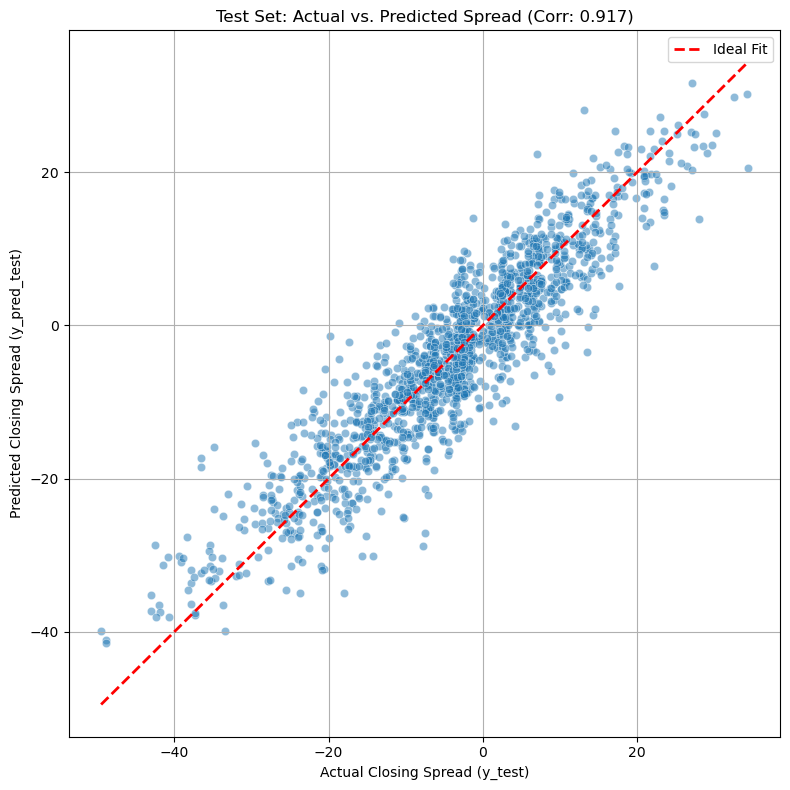


--- Test Set Betting Performance ---
  Total Bets:   1148
  Wins:         601
  Losses:       540
  Pushes:       7
  Win Rate:     52.67%
  Total Units:  +6.31
  ROI:          0.55%


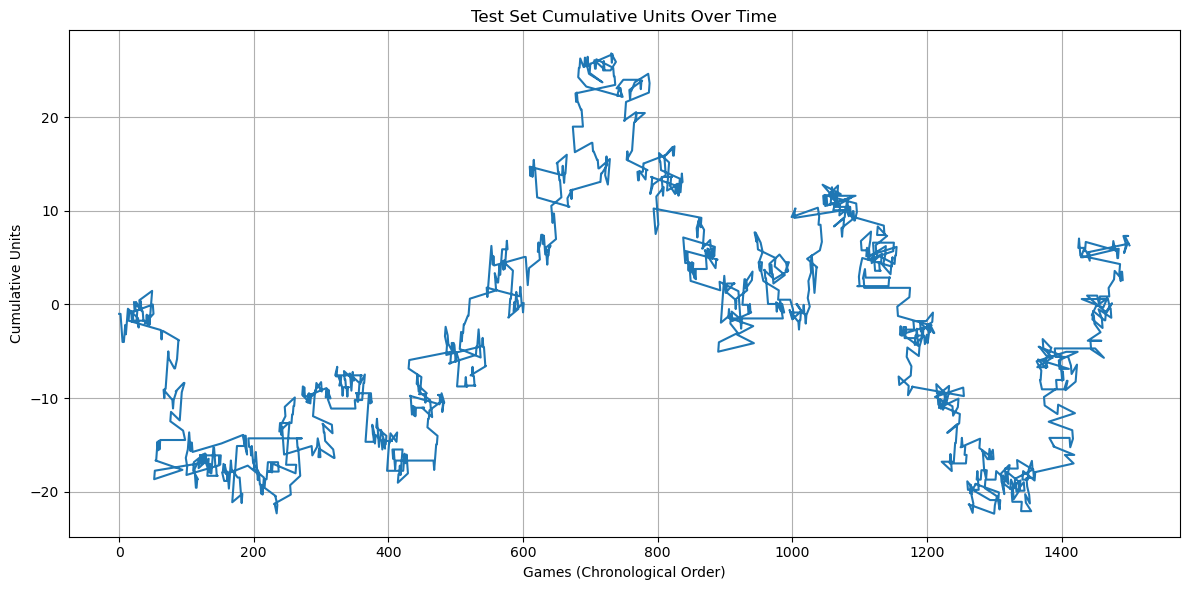

In [17]:
# Evaluate Statistical Metrics on Test Set
win_rate = MF.evaluate_model_statistics(y_test, y_pred_test, predictions_test_series, test_df, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)

## Save Final Model

In [18]:
import json
final_model.save_model("final_model.json")
with open('final_model_best_features.json', 'w') as f:
    json.dump(best_features, f)
